# Import the Libraries

In [7]:
# Data Manipulation and Pre-Processing
import pandas as pd
import numpy as np
from functools import reduce
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model selection and evalution
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import optuna

# Model saving
import os
import pickle

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# Import the Data

In [8]:
# Import the data

data_names = ['contract', 'internet', 'personal', 'phone']

for name in data_names:
    try:
        globals()[f'df_{name}'] = pd.read_csv(f'{name}.csv')
    except:
        globals()[f'df_{name}'] = pd.read_csv(f'/datasets/final_provider/{name}.csv')

## Data Analysis

In [9]:
def data_analysis(df):
    """
    Extract all information we want from a dataframe
    """
    display(df.head(5))
    print('-'*60)
    df.info()
    print('-'*60)
    print('Number of Duplicated Lines:', df.duplicated().sum())
    print('-'*60)
    print('Number of Missing data', df.isna().sum())
    print('-'*60)
    print('Size of DataFrame', df.shape)
    print('-'*60)
    display(df.describe(include='all'))

### Contract Data

In [10]:
# Analysis of df_contract
data_analysis(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
------------------------------------------------------------
Number of Duplicated Lines: 0
------------------------------------------------------------
Number of Missing data customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
Mo

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [11]:
df_contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


- We will rename all the columns to snake case
- The size of dataframe: (7043,8)
- There are no missing value or duplicated row
- We will need to change the type of BeginDate, EndDate and TotalCharge
- The total charge column has a empty value: " ".
- All the TotalCharges with BeginDate in 2020-02-01 are missing.

### Internet Data

In [12]:
# Analysis of df_contract
data_analysis(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
------------------------------------------------------------
Number of Duplicated Lines: 0
------------------------------------------------------------
Number of Missing data customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
St

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


- We will rename all the columns to snake case
- The size of dataframe: (5517,8)
- There are no missing value or duplicated row

### Personal Data

In [13]:
# Analysis of df_personal
data_analysis(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
------------------------------------------------------------
Number of Duplicated Lines: 0
------------------------------------------------------------
Number of Missing data customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
------------------------------------------------------------
Size of DataFrame (7043, 5)
------------------------------------------------------------


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


- We will rename all the columns to snake case
- The size of dataframe: (7043,8)
- There are no missing value or duplicated row

### Phone Data

In [14]:
# Analysis of df_phone
data_analysis(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
------------------------------------------------------------
Number of Duplicated Lines: 0
------------------------------------------------------------
Number of Missing data customerID       0
MultipleLines    0
dtype: int64
------------------------------------------------------------
Size of DataFrame (6361, 2)
------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


- We will rename all the columns to snake case
- The size of dataframe: (6361,2)
- There are no missing value or duplicated row

### Findings:

- There are no missing or duplicate data in any dataframe.  
- The number of rows is different **across** the dataframes:  
    - `df_contract`: (7043, 8)  
    - `df_internet`: (5517, 8)  
    - `df_personal`: (7043, 5)  
    - `df_phone`: (6361, 2)  
- It is necessary to change the data type of some columns in `df_contract` to *datetime*.  
- The column names in all dataframes will be standardized to *snake_case*.  
- There are 11 rows with empty spaces in the **`TotalCharges`** column in `df_contract`. Since all 11 clients have the same **`BeginDate`**, it is possible that this group of clients has not been billed yet.
- The column **`TotalCharges`** is a object type and need to be changed to float
- All 4 dataframes will be merged in one, because all of then have a `costumer_id` column that can be used to merge.



## Data Transformation

- We will fix some issues identified in the last session and create some features. All the steps are described above:
    1. Change the columns name to snake case
    2. Change empty values
    3. Merge the 4 dataframes in one by customer_id
    4. Change the type os some columns.
    5. Create a target column
    6. Create some features to auxiliate our analysis
    

### df_contract

In [15]:
# Changing the columns name
df_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                       'payment_method', 'monthly_charges', 'total_charges']

# Changing values in total_charges column
df_contract['total_charges'] = df_contract['total_charges'].replace(' ', 0)
df_contract['total_charges'] = df_contract['total_charges'].astype(float)

### df_internet

In [16]:
# Changing the columns name
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

### df_personal

In [17]:
# Fixing the columns name
df_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']



### df_phone

In [18]:
# Fixing the columns name
df_phone.columns = ['customer_id','multiple_lines']

### Merging all 4 dataframes

In [19]:

def merge_dataframes(dataframes, key='customer_id', how='outer'):
    """
    Merges multiple DataFrames on a common key, handling duplicate columns.
    
    """

    # Ensure the key column is in the same format (string) in all DataFrames
    for df in dataframes:
        df[key] = df[key].astype(str)
    
    # Perform sequential merging using functools.reduce
    merged_df = reduce(lambda left, right: pd.merge(left, 
                                                    right, 
                                                    on=key, 
                                                    how=how), 
                        dataframes)
    
    return merged_df


In [20]:
# List of DataFrames to merge
dataframes_list = [df_contract, df_internet, df_personal, df_phone]

# Merging DataFrames
final_df = merge_dataframes(dataframes_list, key='customer_id', how='outer')

# Check the merged DataFrame
final_df.head(5)


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.30,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.40,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.40,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [21]:
# Check the missing values
final_df.isna().sum().nlargest(10)

internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
customer_id             0
begin_date              0
dtype: int64

- The missing values for services will be replaced with `not_subscribed`, this will represent clients that has not been subscribed in the service yet
- The missing values in `end_date` represent active clients. Those values will be used to represent a new columns: `churn`

In [22]:
# Get the columns with missing values
na_columns = [col for col in final_df.columns if final_df[col].isna().sum() > 0]

# Fill the missing values with `not_subscribed`.
final_df[na_columns] = final_df[na_columns].fillna('not_subscribed')

# Check the unqiue values in these columns
for col in na_columns:
    display(final_df[col].value_counts())
    print()

internet_service
Fiber optic       3096
DSL               2421
not_subscribed    1526
Name: count, dtype: int64

online_security
No                3498
Yes               2019
not_subscribed    1526
Name: count, dtype: int64

online_backup
No                3088
Yes               2429
not_subscribed    1526
Name: count, dtype: int64

device_protection
No                3095
Yes               2422
not_subscribed    1526
Name: count, dtype: int64

tech_support
No                3473
Yes               2044
not_subscribed    1526
Name: count, dtype: int64

streaming_tv
No                2810
Yes               2707
not_subscribed    1526
Name: count, dtype: int64

streaming_movies
No                2785
Yes               2732
not_subscribed    1526
Name: count, dtype: int64

multiple_lines
No                3390
Yes               2971
not_subscribed     682
Name: count, dtype: int64

In [23]:
final_df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

- All missing data was filled with 'not_subscribed'. 

### Create of target column

- We will create an additional column churn using the end_date column. 
- The `No` values indicate the customers are still active
- Other values indicate the service terminated date.

In [24]:
# Create the target `churn` by using the `end_date` column
final_df['churn'] = final_df['end_date'].map(lambda date: 0 if date == 'No' else 1)

# Check if the column is correctly created
final_df[['end_date', 'churn']].head()

,end_date,churn
0,No,0
1,No,0
2,2020-01-01 00:00:00,1
3,2020-01-01 00:00:00,1
4,2019-12-01 00:00:00,1


### Correction of total_charges empty space problem

In [25]:
# Replace the `No` in `end_date` with None
final_df['end_date'].replace('No', np.nan, inplace=True)

# Check if the replacement has been made
final_df['end_date'].head()

0                    NaN
1                    NaN
2    2020-01-01 00:00:00
3    2020-01-01 00:00:00
4    2019-12-01 00:00:00
Name: end_date, dtype: object

In [26]:
# Replace the blank value in `total_charges` with `0`
final_df['total_charges'].replace(' ', 0, inplace=True)

# Check if there are 11 rows with `0` in `total_charges`
len(final_df.query('total_charges == 0'))

11

### Convert Columns to Date type

In [27]:
# Convert the data types
final_df['begin_date'] = pd.to_datetime(final_df['begin_date'], format='%Y-%m-%d')
final_df['end_date'] = pd.to_datetime(final_df['end_date'], format='%Y-%m-%d %H:%M:%S')
final_df['total_charges'] = final_df['total_charges'].astype(float)

In [28]:
final_df[['begin_date', 'end_date', 'total_charges']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   begin_date     7043 non-null   datetime64[ns]
 1   end_date       1869 non-null   datetime64[ns]
 2   total_charges  7043 non-null   float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 165.2 KB


- Convertion was done correctly.

### Correction in Total_charges Value Problem

- The monthly_charges for February 2020 has not been added to the total_charges since the 11 new customers do not have any payment record in the total_charges. 
- We will add the monthly_charges to the total_charges for the active customers.

In [693]:
# Before correction

final_df.query('begin_date == "02-01-2020"').head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn
945,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,0.0,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,not_subscribed,0
1731,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.0,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Female,0,Yes,Yes,No,0
1906,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,0.0,DSL,Yes,...,No,Yes,No,No,Male,0,No,Yes,Yes,0
2025,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.0,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Male,0,Yes,Yes,No,0
2176,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.0,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Male,0,No,Yes,No,0


In [694]:
final_df['total_charges'] = (final_df['total_charges'] + final_df['monthly_charges']).where(final_df['churn'] == 0, final_df['total_charges'])

In [695]:
# After correction

final_df.query('begin_date == "02-01-2020"').head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,churn
945,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,56.05,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,not_subscribed,0
1731,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,20.00,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Female,0,Yes,Yes,No,0
1906,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,61.90,DSL,Yes,...,No,Yes,No,No,Male,0,No,Yes,Yes,0
2025,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,19.70,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Male,0,Yes,Yes,No,0
2176,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25,not_subscribed,not_subscribed,...,not_subscribed,not_subscribed,not_subscribed,not_subscribed,Male,0,No,Yes,No,0


- The values in total_charges were fixed

### Creating Features

- We expected that custumers with long subscription duration and use more services are less likely to churn. Therefore, we will create new features to analyse costumers behavior.

#### Number of days and Years Subscribed

In [696]:
# Create the datetime value when the data was extracted
extract_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')

# Calculate the total days of subscription
final_df['subscribed_days'] = (final_df['end_date'] - final_df['begin_date']) \
                            .where(final_df['churn'] == 1, extract_date - final_df['begin_date']) \
                            .dt.days

# Calculate the total years of subscription
final_df['subscribed_years'] = (final_df['end_date'].dt.year - final_df['begin_date'].dt.year) \
                             .where(final_df['churn'] == 1, 2020 - final_df['begin_date'].dt.year)

final_df[['churn', 'begin_date', 'end_date', 'subscribed_days', 'subscribed_years']].head()

,churn,begin_date,end_date,subscribed_days,subscribed_years
0,0,2019-05-01,NaT,276,1.0
1,0,2019-05-01,NaT,276,1.0
2,1,2019-09-01,2020-01-01,122,1.0
3,1,2018-12-01,2020-01-01,396,2.0
4,1,2019-09-01,2019-12-01,91,0.0


#### Number of Services and Internet Services Subscribed

In [697]:
# Create a list of internet services provided by the telecom operator
internet_services = ['online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies']

# Define a function to calculate `total_internet_services` for each customer
def calc_total_internet_services(row):
    '''
    Calculate and return total number of subsribed internet services of a customer
    '''
    count = 0

    for service in internet_services:
        if row[service] == 'Yes':
            count += 1

    return count

In [698]:
# Calculate the `total_internet_services`
final_df['total_internet_services'] = final_df.apply(calc_total_internet_services, axis=1)

In [699]:
# Have a check on the `total_internet_services` column
final_df[internet_services + ['total_internet_services']].sample(5)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,total_internet_services
984,Yes,No,Yes,Yes,Yes,Yes,5
1362,No,No,No,No,No,Yes,1
5938,No,Yes,No,No,Yes,Yes,3
5508,No,No,No,Yes,Yes,No,2
3965,Yes,Yes,No,No,Yes,Yes,4


In [700]:
# Define a funtion to calculate `total_services` for each customer
def assign_service_type(row):
    '''
    Assign the type of service subscribed by a customer.
    '''
    if row['internet_service'] != 'not_subscribed' and row['multiple_lines'] == 'not_subscribed':
        return 'internet_service'
    elif row['internet_service'] == 'not_subscribed' and row['multiple_lines'] != 'not_subscribed':
        return 'landline_communication'
    else:
        return 'both'

In [701]:
# Assign the `subscribed_services`
final_df['subscribed_service'] = final_df.apply(assign_service_type, axis=1)

final_df[['internet_service', 'multiple_lines', 'subscribed_service']].sample(5)

,internet_service,multiple_lines,subscribed_service
5010,DSL,Yes,both
1071,not_subscribed,No,landline_communication
5382,not_subscribed,No,landline_communication
3535,DSL,not_subscribed,internet_service
2468,not_subscribed,No,landline_communication


# Exploratory Data Analysis

In [702]:
def plot_filled_bar_chart(data, x, title, legend=True):
    '''
    Plot a filled bar chart to show the distribution of active customers 
    and customer who have left given a feature
    '''
    palette = ['steelblue', 'tomato']
    sns.histplot(data=data, x=x, hue='churn', multiple='fill', discrete=True, 
                 palette=palette, legend=legend, ax=ax)
    ax.set_title(title, fontweight='bold', y=1.0)
    ax.set_xlabel('')    
    ax.set_ylabel('Percentage', fontweight='bold')
    ax.set_yticks(np.linspace(0, 1, 6), np.arange(0, 101, 20))
    
    if legend == True:
        legend_labels = ['active', 'churn']
        legend_handles = [Line2D([0], [0], color=palette[0], lw=3),
                          Line2D([0], [0], color=palette[1], lw=3)]
        ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

## Monthly Payment for Active Customers and Churn

In [703]:
active_customers = final_df.query('churn == 0')
churn_customers = final_df.query('churn == 1')

print('Active Customers:')
display(active_customers['monthly_charges'].describe())
print('-'*60)
print('Churn Customers:')
display(churn_customers['monthly_charges'].describe())

Active Customers:


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthly_charges, dtype: float64

------------------------------------------------------------
Churn Customers:


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64

- Both groups have similar minimum and maximum values
- The mean monthly payment for the churn group (74.44) is higher than the active customers (61.26)
- There are significantly differences between the quartiles of both groups

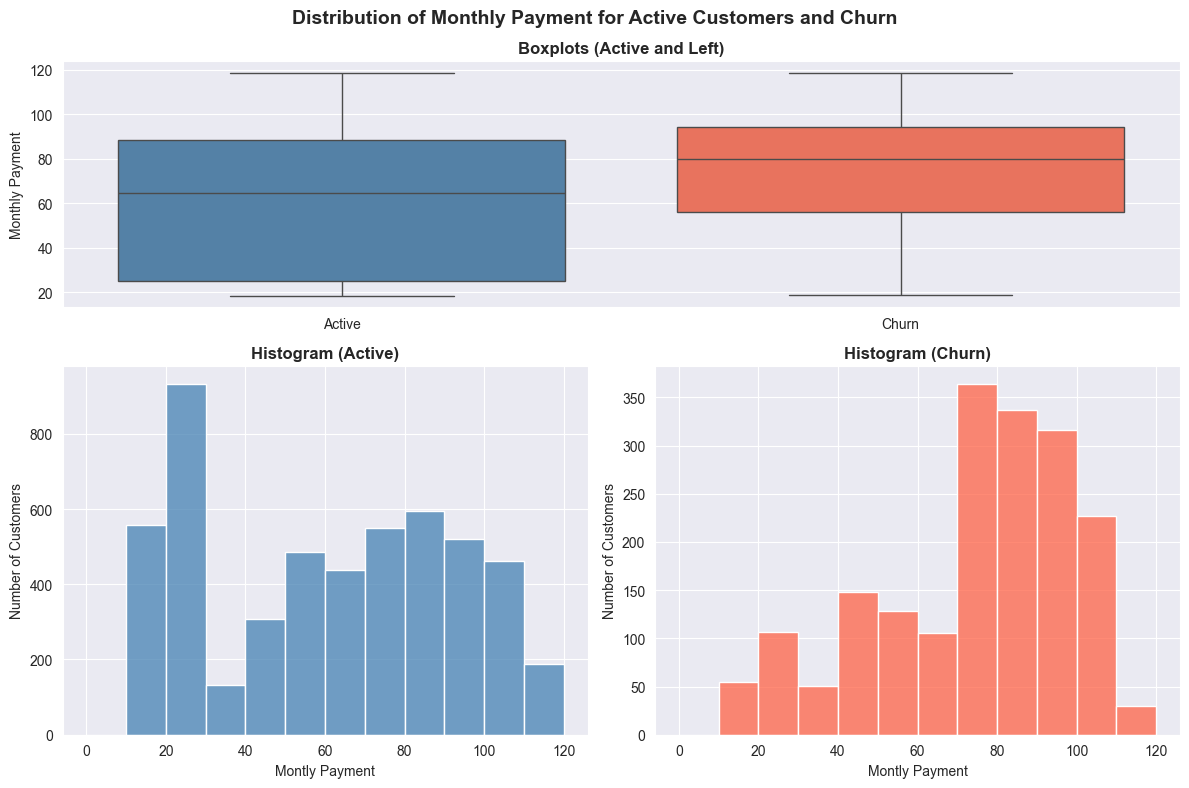

In [704]:
# Plot of histogram and boxplot to visualise distributions

sns.set_style('darkgrid')
 
layout = '''
    aa
    bc
'''

fig, axd = plt.subplot_mosaic(layout,height_ratios=[1.0, 1.5], figsize = (12,8))

fig.suptitle('Distribution of Monthly Payment for Active Customers and Churn', fontsize = 14, fontweight = 'bold')

# Plot the Boxplot
ax = axd['a']
sns.boxplot(data = final_df, x='churn', y='monthly_charges', hue='churn',
            palette=['steelblue', 'tomato'], legend=None, ax=ax)
ax.set_title('Boxplots (Active and Left)', fontweight='bold')
ax.set_xticks([0, 1], ['Active', 'Churn'])
ax.set_xlabel('')
ax.set_ylabel('Monthly Payment')

# Plot the Histogram
ax = axd['b']
sns.histplot(data = active_customers, x='monthly_charges', ax=ax,
             bins=np.arange(0, 121, 10), color = 'steelblue')
ax.set_title('Histogram (Active)', fontweight = 'bold')
ax.set_xlabel('Montly Payment')
ax.set_ylabel('Number of Customers')

ax = axd['c']
sns.histplot(data = churn_customers, x='monthly_charges', ax=ax, 
             bins=np.arange(0, 121, 10), color = 'tomato')
ax.set_title('Histogram (Churn)', fontweight = 'bold')
ax.set_xlabel('Montly Payment')
ax.set_ylabel('Number of Customers')



plt.tight_layout()
plt.show()

- The boxplot shows that churn happens with higher payments than the active clients
- We can divide the custumers in groups based in monthly payment to understand what group has the more chance to churn:
    - 0 to 40
    - 40 to 70
    - 70 to 100
    - 100 and above

In [705]:
customers_groups = pd.cut(
    final_df['monthly_charges'],
    bins=[0, 40, 70, 100, 120],
    labels=['0 to 40', '0 to 70', '70 to 100', '100 and above']
).to_frame()

customers_groups['churn'] = final_df['churn']

pivot = customers_groups.pivot_table(
    index='monthly_charges',
    columns='churn',
    aggfunc='size'
)

pivot_perc = (pivot.div(pivot.sum(axis=1), axis=0)*100).round(2)

pivot_perc

churn,0,1
monthly_charges,,
0 to 40,88.36,11.64
0 to 70,76.08,23.92
70 to 100,62.18,37.82
100 and above,71.95,28.05


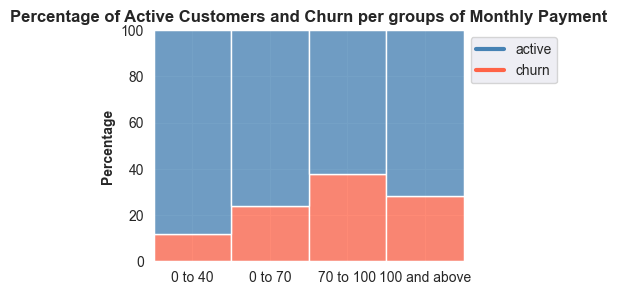

In [706]:
sns.set_style('darkgrid')
plt.figure(figsize=(4,3))

ax = plt.gca()
plot_filled_bar_chart(data=customers_groups,
                      x= 'monthly_charges',
                      title='Percentage of Active Customers and Churn per groups of Monthly Payment')

- The group who pay 70 to 100 per month has the highest churn rate --> 37.82%
- It is possible to focus on that group to avoid churn

## Active and Churn Share Per Services

In [707]:
pivot = final_df.pivot_table(
    index='subscribed_service',
    columns='churn',
    aggfunc='size'
)

pivot_perc = (pivot.div(pivot.sum(axis=1), axis=0)*100).round(2)

pivot_perc

churn,0,1
subscribed_service,,
both,67.20,32.80
internet_service,75.07,24.93
landline_communication,92.60,7.40


- Customers that are subscribed only in **`landline_communication`** have the lowest rate of churn
- Clients subscribed only in Internet Services or in Both Services have almost the same rate of churn
- It is possible that the Internet Service is the reason of churn

## Customer Subscription and Churn by date

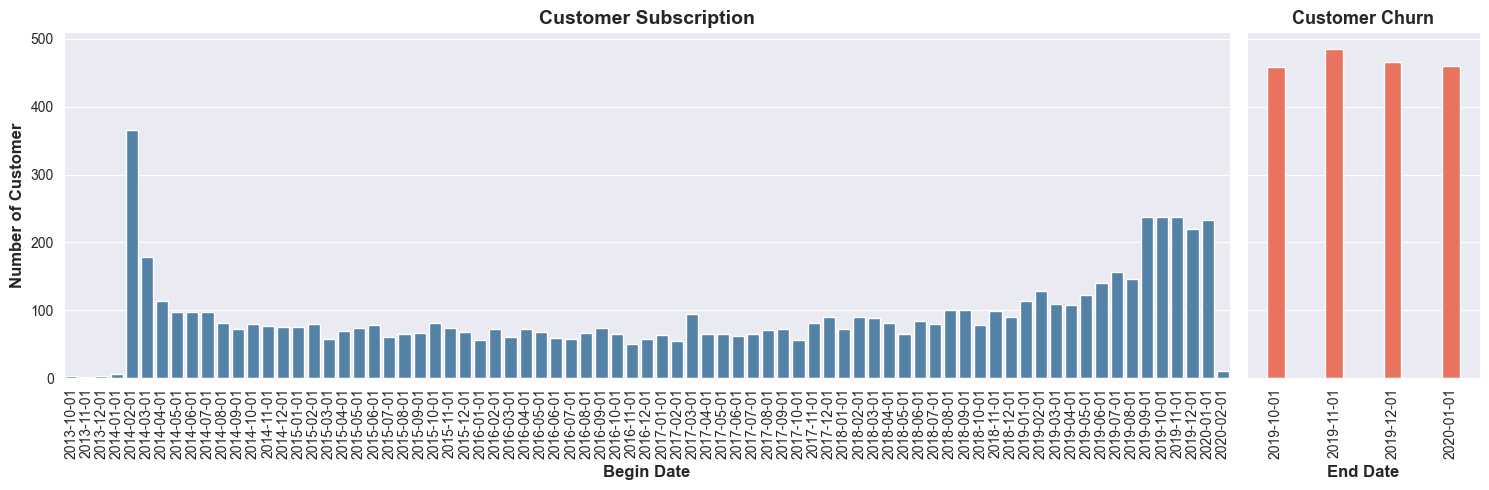

In [708]:
# Plot bar charts to view the customer joining and leaving dates
sns.set_style('darkgrid')

fig, axs = plt.subplots(1, 2, width_ratios=[5.0, 1.0], sharey=True, figsize=(15, 5))

# The joining dates
df_t = final_df['begin_date'].value_counts().sort_index()
ax = axs[0]
sns.barplot(x=df_t.index, y=df_t.values, color='steelblue', ax=ax)
ax.set_title('Customer Subscription', fontsize=14, fontweight='bold')
ax.set_xlabel('Begin Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Customer', fontsize=12, fontweight='bold')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

# The churn dates
df_t = final_df['end_date'].value_counts().sort_index()
ax = axs[1]
sns.barplot(x=df_t.index, y=df_t.values, color='tomato', width=0.3, ax=ax)
ax.set_title('Customer Churn', fontsize=13, fontweight='bold')
ax.set_xlabel('End Date', fontsize=12, fontweight='bold')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

- The churn is concentrated in 4 months: octuber/2019 and january/2020.
- It is possible that the data was colected in february/2020, so the churn rate could be the same.
- The customers outflow is almost the doble of inflow in the same time period

## Churn rate per Type of Contract

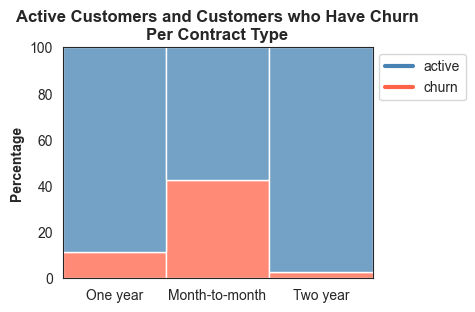

In [709]:
# Plot a filled bar chart
sns.set_style('white')
plt.figure(figsize=(4, 3))

ax = plt.gca()
plot_filled_bar_chart(data=final_df,
                      x='type',
                      title='Active Customers and Customers who Have Churn\nPer Contract Type')

plt.show()

- Custumers with Month-to-Month contracts have the highest churn rate
- The business department could work on convert this costumers in annual subscribers

### Churn Rate per Number of Services 

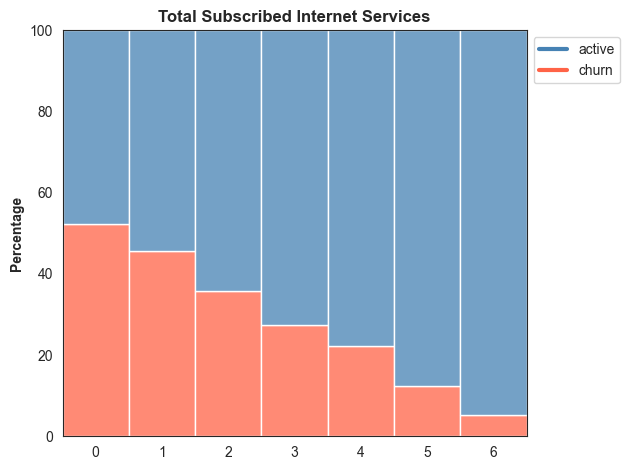

In [710]:
# Plot  filled bar charts
ax = plt.gca()
plot_filled_bar_chart(data=final_df.query('internet_service != "not_subscribed"'),
                      x='total_internet_services',
                      title='Total Subscribed Internet Services',
                      legend=True)

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(np.arange(0, 7))
ax.set_xlim(-0.5, 6.5)

plt.tight_layout()
plt.show()

- Customers with more services have the lowest rate of churn
- The business department could offer more services to clients

## Churn Rate Per Additional Internet Services

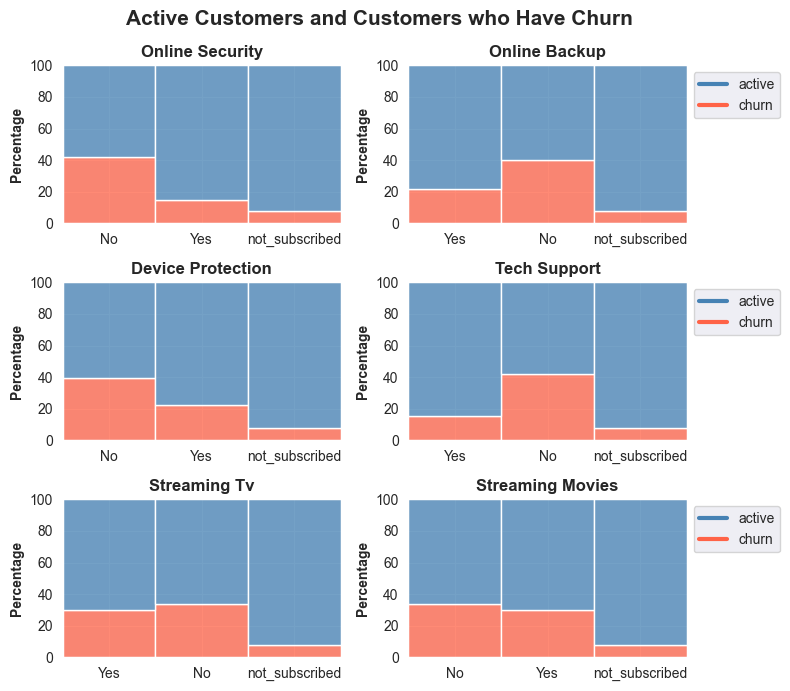

In [711]:
internet_services = ['online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies']

# Plot filled bar charts
nrows, ncols = 3, 2
sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 7))

plt.suptitle('Active Customers and Customers who Have Churn', x=0.48, fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        # Get the service column name
        service = internet_services[i*ncols + j]
        title = ' '.join([word.capitalize() for word in service.split('_')])

        # Plot the filled bar charts, show legend only for right-hand side bar chart
        if j == 0:            
            plot_filled_bar_chart(data=final_df,
                                  x=service,
                                  title=title,                                  
                                  legend=False)
        if j == 1:            
            plot_filled_bar_chart(data=final_df,
                                  x=service,
                                  title=title,                                  
                                  legend=True)

plt.tight_layout()
plt.show()

- Costumers who are subscribed in `Online Security`, `Online Backup`,`Tech Support`, `Device Protection` have the lowest churn rate. This services could be used by the business department to retain costumers.
- Costumers who use or don't use `Streaming TV` and `Streaming Movies` services presents no representative difference 

## Churn rate Per Payment Methods

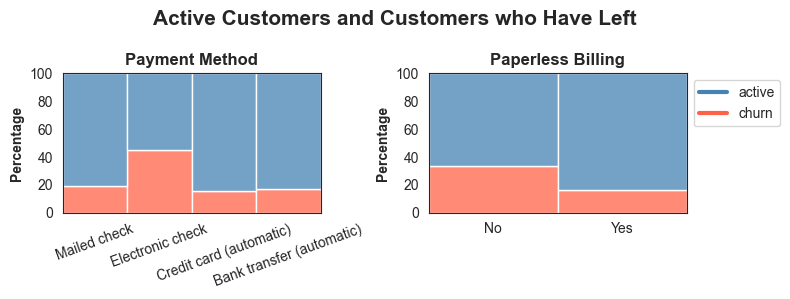

In [712]:
# Plot  filled bar charts
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.suptitle('Active Customers and Customers who Have Left', fontsize=15, fontweight='bold')

ax = axs[0]
plot_filled_bar_chart(data=final_df,
                      x='payment_method',
                      title='Payment Method',
                      legend=False)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)

ax = axs[1]
plot_filled_bar_chart(data=final_df,
                      x='paperless_billing',
                      title='Paperless Billing',
                      legend=True)
ax.set_xticks(np.arange(0, 2), ['No', 'Yes'])


plt.tight_layout()
plt.show()


- Costumers who use Electronic check and Paperless Billing have the highest rate of churn
- Costumers who use Automatic Methods of payment have the lowest rate of churn

## Churn Rate by Personal Characteristc

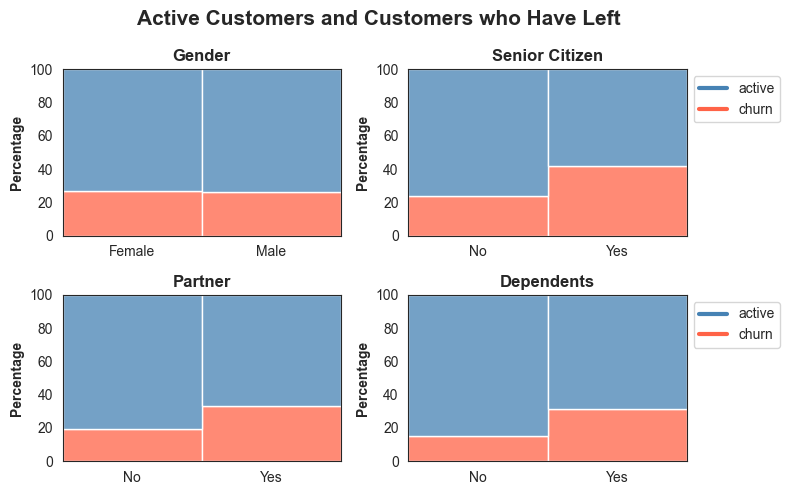

In [713]:
personal_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

# Plot filled bar charts
nrows, ncols = 2, 2
sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 5))

plt.suptitle('Active Customers and Customers who Have Left', x=0.48, fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        # Get the service column name
        personal = personal_columns[i*ncols + j]
        title = ' '.join([word.capitalize() for word in personal.split('_')])

        # Plot the filled bar charts, show legend only for right-hand side bar chart
        if j == 0:            
            plot_filled_bar_chart(data=final_df,
                                  x=personal,
                                  title=title,
                                  legend=False)
        if j == 1:
            service = internet_services[i*ncols + j]
            plot_filled_bar_chart(data=final_df,
                                  x=personal,
                                  title=title,
                                  legend=True)

axs[0][1].set_xticks(np.arange(0, 2), ['No', 'Yes'])
axs[1][0].set_xticks(np.arange(0, 2), ['No', 'Yes'])
axs[1][1].set_xticks(np.arange(0, 2), ['No', 'Yes'])

plt.tight_layout()
plt.show()

- Gender has no significance in churn rate
- Senior Citizen have the highest churn rate
- Churn rate are lower when costumers have partner or dependents 
- Business department could offer more family plans

## Correlation Between Features and Target

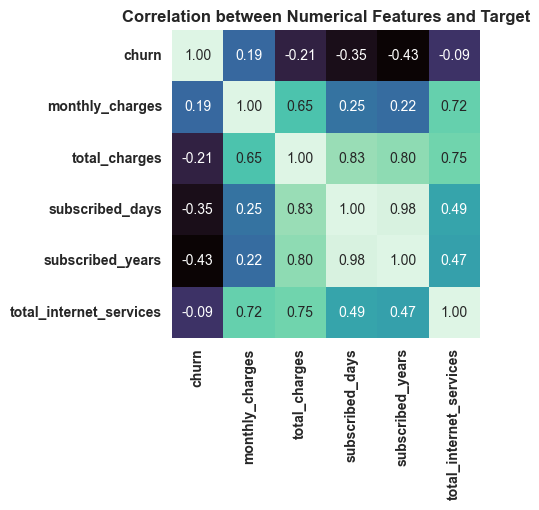

In [714]:
numerical_features = ['monthly_charges', 'total_charges', 'subscribed_days',
                      'subscribed_years', 'total_internet_services']

# Plot the heatmap of correlation coefficients
sns.set_style('white')
plt.figure(figsize=(4, 4))

corr_data = final_df[['churn'] + numerical_features].corr()

sns.heatmap(corr_data, annot=True, fmt='.2f',
            cmap='mako', square=True, cbar=False)

plt.title('Correlation between Numerical Features and Target',
          fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

- There is a negative correlation between churn and the columns **subscribed_days** and **subscribe_year**. This indicates that the longer a customer remains a subscriber, the lower the likelihood of churn.  
- There is a positive correlation between churn and **monthly_charges**, meaning that customers who pay higher monthly fees are more likely to churn.  
- There is a negative correlation between churn and **total_charges**, suggesting that customers who have spent more money over the years are less likely to churn.

# Intermediate Conclusions

### **General Conclusion on Churn Analysis**

1. **Data Quality and Preprocessing**:  
   - No missing or duplicate data were found across the dataframes, ensuring data integrity.
   - Data types and column names were standardized, and missing values were handled appropriately.
   - Customers with missing `TotalCharges` values likely had not been billed yet, and these records required correction.

2. **Merging and Feature Engineering**:  
   - The four datasets were merged using `customer_id`, allowing for a more comprehensive analysis.
   - New features were created to capture customer behavior, including subscription classification and churn prediction.
   - A `churn` feature was derived from missing `end_date` values.

3. **Churn Behavior Insights**:  
   - Customers who pay **higher monthly fees (above $70)** are more likely to churn, suggesting pricing sensitivity.
   - Customers who **stay longer** (higher total charges and subscription duration) are less likely to churn.
   - The highest churn rate (37.82%) is concentrated among customers who pay between **$70 to $100** per month.

4. **Service Subscription Patterns**:  
   - Customers subscribed only to **Multiple Lines** have the **lowest churn rate**.
   - Internet Service alone or in combination with other services has a **higher churn rate**, suggesting dissatisfaction.
   - Streaming services (`Streaming TV`, `Streaming Movies`) have **no significant impact** on churn.
   - Customers subscribed to **Online Security, Online Backup, Tech Support, and Device Protection** have **the lowest churn rate**. These services could be leveraged to increase retention.

5. **Billing and Payment Methods**:  
   - Customers using **Electronic Check and Paperless Billing** have **higher churn rates**.
   - Customers using **automatic payment methods** (credit card, bank transfer) have the **lowest churn rate**.

6. **Customer Demographics and Engagement**:  
   - **Gender does not impact churn rate**.
   - **Senior citizens churn at a higher rate**.
   - Customers with **partners or dependents** are less likely to churn, indicating that family-oriented plans may improve retention.

7. **Contract Type and Business Opportunities**:  
   - Customers on **Month-to-Month contracts** have the **highest churn rate**.
   - **Encouraging customers to switch to annual contracts** could reduce churn.
   - **Offering more bundled services** could improve retention since customers with multiple services tend to stay longer.

# PROJECT WORK:

### **General Task Resolution Plan**  

1. **Review the Exploratory Data Analysis (EDA) and Key Insights**  
   - Summarize the main findings from the EDA to ensure all relevant patterns and correlations are considered.  
   - Identify the most important factors contributing to customer churn, such as pricing, contract type, service usage, and payment methods.  

2. **Data Preprocessing and Feature Engineering**  
   - Clean and transform the data to ensure it is suitable for machine learning models.  
   - Encode categorical variables, standardize numerical features, and handle missing values appropriately.  
   - Engineer new features based on the insights from EDA, such as subscription duration, service usage categories, and payment patterns.  

3. **Model Selection and Training**  
   - Choose appropriate machine learning algorithms to predict churn.  
   - Split the data into training and testing sets to evaluate model performance.  
   - Tune hyperparameters and compare model accuracy, precision, recall, and F1-score to select the best-performing model.  

4. **Model Evaluation and Interpretation**  
   - Assess model performance using key metrics such as ROC-AUC, precision-recall curves, and feature importance analysis.  
   - Interpret the most influential features driving customer churn and validate them against business logic.  
   - Conduct error analysis to identify common misclassifications and potential improvements.  

5. **Final Insights**  
   - Summarize the most critical insights from the predictive model, highlighting key factors influencing churn.
   - Identify customer segments at the highest risk of churn and their characteristics.
   - Provide a data-driven understanding of why customers leave and which variables are most strongly correlated with churn.
   - Highlight unexpected findings or trends that could impact business strategies.

# Modeling

In [715]:
def optimise_model(model, objective, X_train, y_train, X_val, y_val, n_trials, model_name):    
    '''
    Optimise a scikit-learn model with the Optuna library.

    The model is optimised based on a user-defined objective function.
    '''
    # Set the optuna verbosity level to warning only
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Create the optimisation study
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
                                direction='maximize',
                                study_name=f'{model_name}_study')    

    # Optimise the model and show the progress bar
    with tqdm(total=n_trials, desc=f'Optimising {model_name}... ') as pbar:
        def callback(study, trial):
            pbar.update(1)    
        study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    # Print the best hyperparameter found
    print('Best hyperparameters:')
    display(study.best_params)    
    print()
    
    # Recreate the best model
    best_model = model(**study.best_params) 

    # Train the model and record the training time          
    train_start = time.time()
    best_model.fit(X_train, y_train)
    train_end = time.time()
    train_time = round((train_end - train_start) * 1000, 2)

    return best_model, train_time

In [716]:
def evaluate_model(model, X_train, y_train, X_test, y_test, test_set=False):
    '''
    Evaluate the performance of a binary classification model.

    Evaluate the model performance on the training and test sets.
    Display the scores including ROC AUC score and accuracy score.
    Plot the ROC curve and confusion matrix.
    '''
    # Create a dictionary to store the evaluation stats
    eval_stats = {}

    # Plot the ROC curve and confusion matrix
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    for data_type, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):     
        # Create dict to store the train and test stats
        eval_stats[data_type] = {}

        # Get the predict probability and predictions
        # Calculate the prediction time
        pred_proba = model.predict_proba(X)[:, 1]
        pred_start = time.time()
        y_pred = model.predict(X)
        pred_end = time.time()

        # Store the prediction time on the test set
        if data_type == 'test':
            pred_time = round((pred_end - pred_start) * 1000, 2)

        # Get the required data to plot the ROC curve
        fpr, tpr, roc_thresholds = roc_curve(y, pred_proba)
        roc_auc = roc_auc_score(y, pred_proba)        
                
        # Assign colours for train and test sets in the graph
        if data_type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot the ROC curve
        ax = axs[0]
        if data_type == 'train':
            ax.plot(fpr, tpr, color=color, label=f'train, ROC AUC={roc_auc:.4f}')
        else:
            if not test_set:
                ax.plot(fpr, tpr, color=color, label=f'val, ROC AUC={roc_auc:.4f}')
            else:
                ax.plot(fpr, tpr, color=color, label=f'test, ROC AUC={roc_auc:.4f}')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
        ax.set_xlabel('FPR', fontweight='bold')
        ax.set_ylabel('TPR', fontweight='bold')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.legend(loc='lower center', prop={'size': 8, 'weight': 'bold'})
        
        # Make a few point on the curve with selected thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)

        # Plot the confusion matrix on the test set
        if data_type == 'test':
            ax = axs[1]
            sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, square=True,
                        fmt='.0f', annot_kws={'fontsize': 12, 'fontweight': 'bold'}, cbar=False, ax=ax)
            ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
            ax.set_xlabel('Predicted', fontweight='bold')
            ax.set_ylabel('Actual', fontweight='bold')
            ax.set_xticks([0.5, 1.5], ['Active', 'Left'])
            ax.set_yticks([0.5, 1.5], ['Active', 'Left'])
        
        # Store the ROC AUC score and accuracy_score
        eval_stats[data_type]['ROC AUC'] = roc_auc
        eval_stats[data_type]['Accuracy'] = accuracy_score(y, y_pred)

    plt.tight_layout()
    plt.show()
    
    # Get the evaluation result to be shown
    eval_stats_df = pd.DataFrame(eval_stats)
    eval_stats_df = eval_stats_df.round(4).reindex(index=('ROC AUC', 'Accuracy'))    

    # Return the evaluation result as necessary
    if not test_set:
        result = {
            'train_roc_auc': eval_stats_df.loc['ROC AUC', 'train'],
            'val_roc_auc': eval_stats_df.loc['ROC AUC', 'test'],
            'train_acc': eval_stats_df.loc['Accuracy', 'train'],
            'val_acc': eval_stats_df.loc['Accuracy', 'test'],
            'prediction_time (ms)': pred_time
        }

        # Adjust the column names and show the evaluation result
        eval_stats_df.columns = ['train', 'validation']
        display(eval_stats_df)
        
        return result        
    else:
        # Show the evaluation result
        display(eval_stats_df)


In [717]:
def save_model(model, model_path, model_name):
    '''
    Save the trained model.
    '''
    # Delete the model if it exists
    if os.path.isfile(model_path):
        os.remove(model_path)

    # Save the model
    try:
        pickle.dump(model, open(model_path, 'wb'))        
    except Exception as e:
        print('Failed to save the model.')
        print(f'Unexpected Error: {e}')
    else:
        print(f'The {model_name} model has been successfully saved.')

## Features and Target

- To predict churn we will train 6 models:
    - Baseline Model: Constant Model
    - Linear Model: Logistic Regression
    - Tree-based Model: Decision Tree
    - Gradient Boosting: LightGBM, CatBoost, XGBoost

- The first step to training the models is separate the dataset into _features_ and _target_ and remove any unnecessary feature from the dataset, like `costumer_id`,`begin_date`, `end_date`

In [718]:
X = final_df.drop(columns=['customer_id', 'begin_date', 'end_date', 'churn'])
y = final_df['churn']

# Check the shapes of X and y
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (7043, 21)
Shape of y: (7043,)


## One-Hot Encoding

- To ensure that all models can be trained properly, we will perform one-hot encoding on the categorical features

In [719]:
# One-hot encode the categorical features
X_ohe = pd.get_dummies(X, drop_first=True, dtype=int)

# Check the shape of X_ohe
print('Shape of X after one-hot encoding:', X_ohe.shape)

Shape of X after one-hot encoding: (7043, 33)


## Split the Dataset into Training, Validation and Test Sets

- Our dataset will be divided into:
    - 80% -> Training
    - 10% -> Validation
    - 10% -> Test

In [720]:
# Split the dataset into train:val:test = 80:10:10
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=12345)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

# Check the shapes
print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_val', X_val.shape)
print('Shape of y_val', y_val.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (5634, 33)
Shape of y_train (5634,)
Shape of X_val (704, 33)
Shape of y_val (704,)
Shape of X_test (705, 33)
Shape of y_test (705,)


In [721]:
# Check for target imbalance
y_train.value_counts()

churn
0    4125
1    1509
Name: count, dtype: int64

- The dataset was separate into training, validation and test with proportion 80:10:10
- There are imbalance in our dataset, therefore is necessary upsample the minority class

## Features Scaling 

- Features scaling will be performed to auxiliate the gradient boosting models to converge better and faster

In [722]:
numerical_features = ['monthly_charges', 'total_charges', 'subscribed_days', 'subscribed_years', 'total_internet_services']

In [723]:
# Perform feature scaling
sc = StandardScaler()
X_train[numerical_features] = sc.fit_transform(X_train[numerical_features])
X_val[numerical_features] = sc.transform(X_val[numerical_features])
X_test[numerical_features] = sc.transform(X_test[numerical_features])

# Have a check after feature scaling
display(X_train[numerical_features].head(2))
display(X_val[numerical_features].head(2))
display(X_test[numerical_features].head(2))

,monthly_charges,total_charges,subscribed_days,subscribed_years,total_internet_services
1580,0.580083,1.551754,1.620431,1.472133,1.065020
2902,-0.124219,-0.206204,-0.175387,0.040817,0.524061


,monthly_charges,total_charges,subscribed_days,subscribed_years,total_internet_services
3546,0.155845,-0.816454,-1.033031,-0.913393,-1.098818
4268,-1.309103,-0.153967,1.541244,1.472133,-1.098818


,monthly_charges,total_charges,subscribed_days,subscribed_years,total_internet_services
5705,-0.145762,0.786148,1.500979,1.472133,1.605980
1295,-1.463221,-0.347806,1.620431,1.472133,-1.098818


- The feature scaling process has been done correctly

## Upsampling of the Training Set

- We identified imbalance in the target classes. 
- We will perform a Upsampling to adress this issue

In [724]:
# Separate the training set into majority class and minority class
X_major = X_train[y_train == 0]
y_major = y_train[y_train == 0]

X_minor = X_train[y_train == 1]
y_minor = y_train[y_train == 1]

# Get the required size for upsampling the minority class
upsize = len(y_major)

# Upsampling the minority class
X_minor_up = X_minor.sample(upsize, replace=True, random_state=42)
y_minor_up = y_minor.sample(upsize, replace=True, random_state=42)

# Combine the majority and minority classes after upsampling and shuffle
X_train_up = pd.concat([X_major, X_minor_up])
y_train_up = pd.concat([y_major, y_minor_up])

X_train_up, y_train_up = shuffle(X_train_up, y_train_up, random_state=42)

# Check the count of each class after upsamplint
y_train_up.value_counts()

churn
1    4125
0    4125
Name: count, dtype: int64

- The upsampling has been done correctly. Now the churn target is balanced with 50%:50%

## Model Training

In [725]:
# Create dictionaries to store various information for later use
best_model = {}
train_time = {}
result = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

### Constante Model

- This model will be used as a baseline.
- This model always predict the majority class
- No hyperparameters will be tuned

In [726]:
# Set up for the modeling process
model_name = 'Constant'
opt_model = DummyClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {}
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 1

Optimising Constant... : 100%|██████████| 1/1 [00:00<00:00, 288.13it/s]

Best hyperparameters:


{}

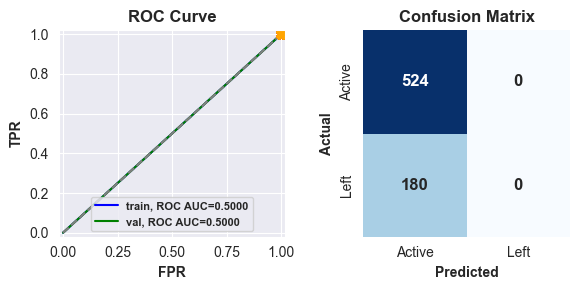

,train,validation
ROC AUC,0.5000,0.5000
Accuracy,0.7322,0.7443


CPU times: total: 172 ms
Wall time: 239 ms


In [727]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train, y_train, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train, y_train, X_val, y_val)

- The ROC AUC scores for both the training and validation sets are 0.5. 
- The accuracy is the percentage of class `Active` in the respective dataset.

In [728]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Constant model has been successfully saved.


### Logistic Regression

- Hyperparameter to be tuned:
    - `C`: The cost of misclassifying labels and it is the inverse of the regularisation strength. The larger the C, the more complex the model is and can possibly lead to overfitting.

In [729]:
# Set up for the modeling process
model_name = 'Logistic Regression'
opt_model = LogisticRegression

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

Optimising Logistic Regression... : 100%|██████████| 100/100 [00:06<00:00, 16.64it/s]

Best hyperparameters:


{'C': 54.5584970285496}

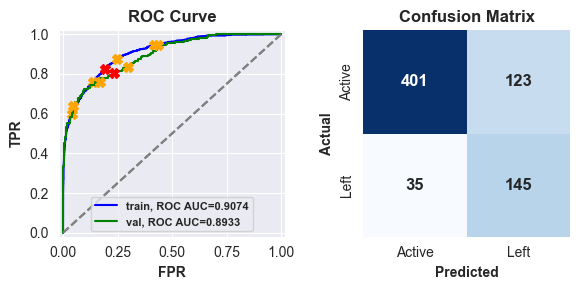

,train,validation
ROC AUC,0.9074,0.8933
Accuracy,0.8148,0.7756


CPU times: total: 1.22 s
Wall time: 6.29 s


In [730]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

- The logistic regression model has a validation ROC AUC score of 0.8933. 
- From the confusion matrix, it can be seen that the model does not have a good performance in predicting the majority class 0.

In [731]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Logistic Regression model has been successfully saved.


### Decision Tree

- The hyperparameter to be tuned:
    - `max_depth`: The maximum depth of the decision tree. If the value is too low, the model might not be able to generalise well. However, a high value might cause overfitting.

In [732]:
# Set up for the modeling process
model_name = 'Decision Tree'
opt_model = DecisionTreeClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'max_depth': trial.suggest_int('max_depth', 2, 30)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 20

Optimising Decision Tree... : 100%|██████████| 20/20 [00:00<00:00, 27.72it/s]

Best hyperparameters:


{'max_depth': 8}

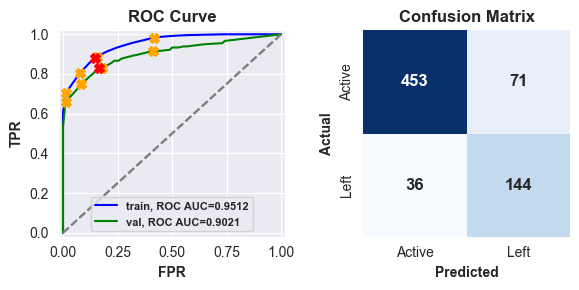

,train,validation
ROC AUC,0.9512,0.9021
Accuracy,0.8673,0.8480


CPU times: total: 766 ms
Wall time: 977 ms


In [733]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

- The decision tree model has a validation ROC AUC score of 0.9021 which is better than the logistic regression model. 
- The model has a overfitting issue.

In [734]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Decision Tree model has been successfully saved.


### LightGBM

- The hyperparameters to tuned are:
    - `num_leaves`: The complexity of the model increases with the number of leaves. Therefore, a high number of leaves may lead to overfitting.
    - `max_depth`: The maximum depth of a single tree.
    - `n_estimators`: The total number of trees. This number should be large enough to reduce the variance and prevent model from being overfitting. However, it will be computational expensive for a large number of trees.
    - `learning_rate`: This parameter decides the step size of the gradient descent in the optimisaton process. A small value may not find the optimised value if the number of trees is not large enough. A large value speeds up the training speed but may overshoot the optimised value.
    - `reg_alpha`: The L1 regularisation which penalise large weights on the features and thus prevent overfitting. L1 regularisation encourages the sparsity in the features (the weight can be zero)
    - `reg_lambda`: The L2 regularisation. This L2 regularisation is similar to the L1 regularisation but does not enforce sparsity.

In [744]:
# Set up for the modeling process
model_name = 'LightGBM'
opt_model = LGBMClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'num_leaves': trial.suggest_int('num_leaves', 4, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 500),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

Optimising LightGBM... : 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]

Best hyperparameters:


{'num_leaves': 46,
 'max_depth': 459,
 'n_estimators': 144,
 'learning_rate': 0.28011252362691835,
 'reg_alpha': 1.1534383868211915,
 'reg_lambda': 0.04480691652004276,
 'verbose': -1}

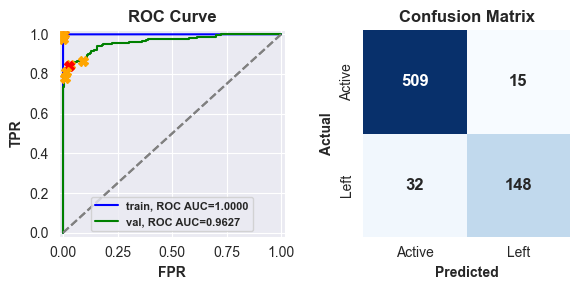

,train,validation
ROC AUC,1.0000,0.9627
Accuracy,0.9988,0.9332


CPU times: total: 1min 30s
Wall time: 43.3 s


In [745]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

- The LightGBM model has a validation ROC AUC score of 0.9627, which make it the best model at the moment. 
- The performance on both the majority and minority classes are also improved.

In [746]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The LightGBM model has been successfully saved.


### CatBoost

- The hyperparameters to be tuned are:
    - max_depth
    - n_estimators
    - learning_rate
    - reg_lambda

In [737]:
# Set up for the modeling process
model_name = 'CatBoost'
opt_model = CatBoostClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'max_depth': trial.suggest_int('max_depth', 3, 16),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),        
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_categorical('verbose', [False])
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

Optimising CatBoost... : 100%|██████████| 100/100 [10:40<00:00,  6.41s/it]

Best hyperparameters:


{'max_depth': 3,
 'n_estimators': 284,
 'learning_rate': 0.15473492846120235,
 'reg_lambda': 0.029135277554386885,
 'verbose': False}

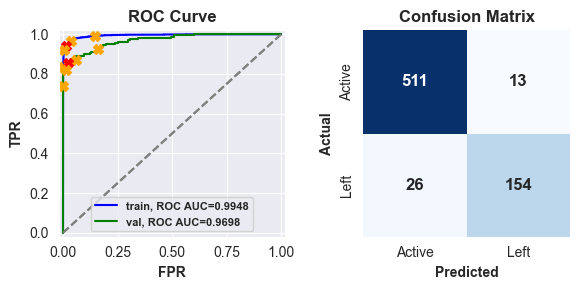

,train,validation
ROC AUC,0.9948,0.9698
Accuracy,0.9632,0.9446


CPU times: total: 30min 31s
Wall time: 10min 42s


In [738]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

- The CatBoost model achieves an even better validation ROC AUC score of 0.9698 compared to the LightGBM model.

In [740]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The CatBoost model has been successfully saved.


### XGBoost

- The hyperparameters to be tuned are:
    - num_leaves
    - max_depth
    - n_estimators
    - learning_rate
    - reg_alpha
    - reg_lambda

In [741]:
# Set up for the modeling process
model_name = 'XGBoost'
opt_model = XGBClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'num_leaves': trial.suggest_int('num_leaves', 4, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 500),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

Optimising XGBoost... : 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

Best hyperparameters:


{'num_leaves': 47,
 'max_depth': 5,
 'n_estimators': 285,
 'learning_rate': 0.25450697647918435,
 'reg_alpha': 0.002460672015811655,
 'reg_lambda': 0.0033499971284827504,
 'verbose': -1}

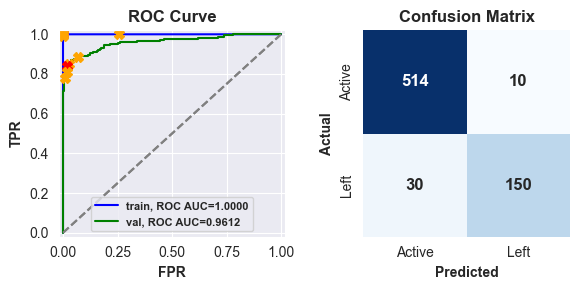

,train,validation
ROC AUC,1.0000,0.9612
Accuracy,0.9999,0.9432


CPU times: total: 11min 7s
Wall time: 1min 49s


In [742]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

- The XGBoost model has a validation ROC AUC score of 0.9612 which is the lowest among the three gradient boosting ensembles.

In [743]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The XGBoost model has been successfully saved.


### Conclusion of Modeling Step

#### **Features and Target Selection**
- Six machine learning models will be trained, including a **baseline model**, a **logistic regression model**, a **decision tree**, and three **gradient boosting models** (LightGBM, CatBoost, XGBoost).
- The dataset will be split into **features** and **target**, removing unnecessary columns such as `customer_id`, `begin_date`, and `end_date`.

#### **One-Hot Encoding**
- Categorical variables will be transformed using **one-hot encoding** to ensure compatibility with machine learning models.

#### **Dataset Splitting and Handling Imbalance**
- The dataset will be split into **training (80%)**, **validation (10%)**, and **test (10%)** sets.
- As the target variable is **imbalanced**, upsampling will be applied to balance the classes.

#### **Feature Scaling**
- Feature scaling will be performed to help **gradient boosting models** converge more efficiently.

#### **Upsampling of the Training Set**
- The **minority class (churned customers)** will be upsampled to achieve a **50:50 balance** in the training set.

---

### **Model Training and Evaluation**

#### **Baseline Model (Constant Model)**
- The baseline model always predicts the majority class.
- ROC AUC score is **0.5**, setting a benchmark for comparison.

#### **Logistic Regression**
- The model's **C parameter** (regularization strength) will be tuned.
- The validation **ROC AUC score is 0.8933**, but it struggles to predict the majority class.

#### **Decision Tree**
- The **max_depth** parameter will be tuned to avoid underfitting or overfitting.
- The validation **ROC AUC score is 0.9021**, but the model overfits the training data.

#### **Gradient Boosting Models**

##### **LightGBM**
- Key parameters to tune: **num_leaves, max_depth, n_estimators, learning_rate, reg_alpha, reg_lambda**.
- Validation **ROC AUC score: 0.9627**, showing improved performance.

##### **CatBoost**
- Key parameters: **max_depth, n_estimators, learning_rate, reg_lambda**.
- **Best validation score: 0.9698**, outperforming all previous models.

##### **XGBoost**
- Key parameters: **num_leaves, max_depth, n_estimators, learning_rate, reg_alpha, reg_lambda**.
- **Validation score: 0.9612**, slightly lower than LightGBM and CatBoost.

# Model Evaluation

In [748]:
# Merge the recorded result
result_df = pd.merge(
    pd.DataFrame(result).transpose(),
    pd.DataFrame([train_time]).transpose().rename(columns={0: 'training_time (ms)'}),
    left_index = True,
    right_index = True
).sort_values('val_roc_auc', ascending=False)

result_df

,train_roc_auc,val_roc_auc,train_acc,val_acc,prediction_time (ms),training_time (ms)
CatBoost,0.9948,0.9698,0.9632,0.9446,2.00,1625.35
LightGBM,1.0000,0.9627,0.9988,0.9332,15.62,302.69
XGBoost,1.0000,0.9612,0.9999,0.9432,34.80,626.17
Decision Tree,0.9512,0.9021,0.8673,0.8480,15.66,41.71
Logistic Regression,0.9074,0.8933,0.8148,0.7756,0.00,46.97
Constant,0.5000,0.5000,0.7322,0.7443,0.00,0.00


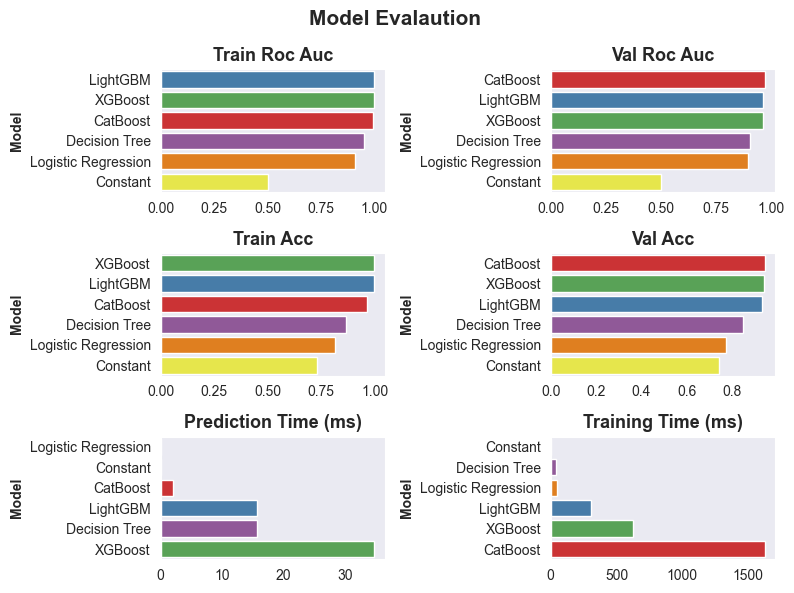

In [749]:
# Plot bar charts to visualise the result
nrows, ncols = 3, 2
sns.set_style('dark')

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 6))

fig.suptitle('Model Evalaution', fontsize=15, fontweight='bold')

# Assign a specific color for each models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

# Plot the bar charts
for i in range(nrows):
    for j in range(ncols):
        col = result_df.columns[i*ncols + j]
        if 'time' in col:
            col_data = result_df[col].sort_values()
        else:
            col_data = result_df[col].sort_values(ascending=False)

        ax = axs[i][j]
        sns.barplot(y=col_data.index, x=col_data.values, hue=col_data.index, palette=model_colors, ax=ax)
        title = ' '.join([word.capitalize() for word in col.split('_')])
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Model', fontweight='bold')

plt.tight_layout()
plt.show()

**Model Evaluation**

- All the models outperform the baseline constant model. The gradient boosting ensembles demonstrate superior performance compared to other models.
- Each model shows mild to moderate overfitting, especially the XGBoost and decision tree models.
- The XGBoost model requires more time for predictions than the other models, while the CatBoost model has the longest training duration.
- **The CatBoost model which has the highest validation ROC AUC score of 0.9698 is chosen as the final model. Additonally, the model also has the fastest prediction time among the three gradient boosting ensembles.**

**Features Importance**

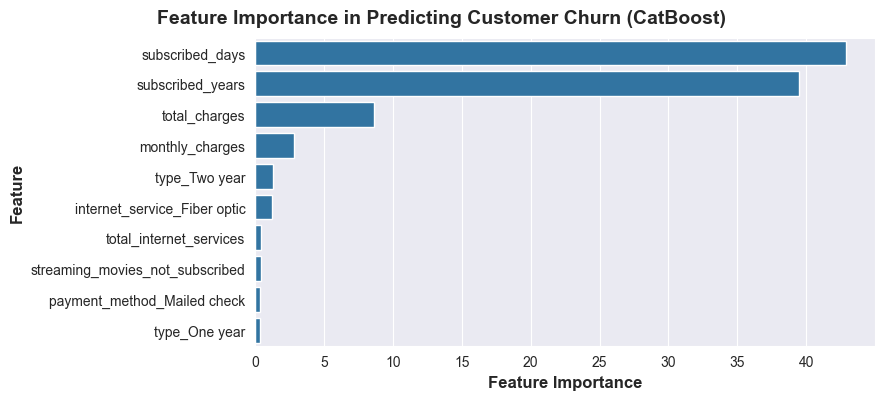

In [751]:
# Find the feature importances returned by the CatBoost model
feature_importance = pd.DataFrame({
    'feature': best_model['CatBoost'].feature_names_,
    'feature_importance': best_model['CatBoost'].feature_importances_
}).sort_values('feature_importance', ascending=False)

# Plot a bar chart to visualise the top 10 features
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4))

sns.barplot(data=feature_importance[:10], y='feature', x='feature_importance')
plt.title('Feature Importance in Predicting Customer Churn (CatBoost)', x=0.3, y=1.02, fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')

plt.show()

## Evaluation of the Final Model on the Test Set

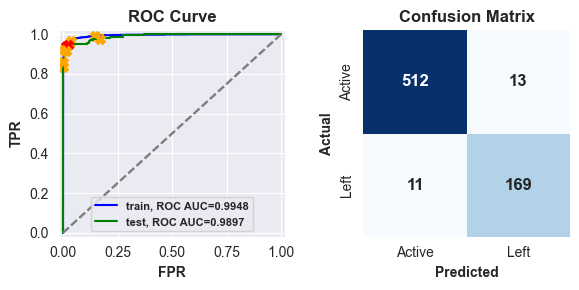

,train,test
ROC AUC,0.9948,0.9897
Accuracy,0.9632,0.9660


In [752]:
# Evaluate the final model on the test set
evaluate_model(best_model['CatBoost'], X_train_up, y_train_up, X_test, y_test, test_set=True)

- The CatBoost model maintains a consistent performance on the test set with a ROC AUC score of 0.9897 and an accuracy of 0.9660. 
- The model shows a less satisfactory results in predicting the minority class Left. To verify this, we will examine the classification report.

In [755]:
# Print the classification report of CatBoost
print(classification_report(y_test, best_model['CatBoost'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       525
           1       0.93      0.94      0.93       180

    accuracy                           0.97       705
   macro avg       0.95      0.96      0.96       705
weighted avg       0.97      0.97      0.97       705



- Comparing the recall and f1-score, the CatBoost model exhibits a slightly inferior performance in predicting the minority class.

In [756]:
# Sanity check the lgbm model with the linear regression model
base_roc_auc = roc_auc_score(y_test, best_model['Constant'].predict(X_test))
cat_roc_auc = roc_auc_score(y_test, best_model['CatBoost'].predict(X_test))

print('The CatBoost model outperforms the linear regression model on test set by ', end='')
print(f'{(cat_roc_auc / base_roc_auc) - 1:.2%}')

The CatBoost model outperforms the linear regression model on test set by 91.41%


### **Model Evaluation and Final Selection**
- **Gradient boosting models outperform the logistic regression and decision tree.**
- **CatBoost achieves the highest validation ROC AUC score (0.9698) and is chosen as the final model.**  
- The model maintains strong performance on the **test set (ROC AUC: 0.9897, Accuracy: 0.9660).**
- Some limitations: the model struggles with **minority class prediction**, confirmed by the classification report.
- Overall, **CatBoost is the best model** due to its **high accuracy and fast prediction time** compared to XGBoost and LightGBM.

### **Final Conclusion**

The analysis and modeling process provided valuable insights into customer churn behavior and led to the development of a high-performing predictive model. 

1. **Key Business Insights:**  
   - Customers paying **higher monthly fees ($70–$100)** are at the highest risk of churn.  
   - **Internet service dissatisfaction** appears to be a significant churn driver.  
   - **Electronic check and paperless billing methods** are associated with higher churn rates.  
   - Customers on **month-to-month contracts** have the highest churn, emphasizing the importance of **long-term subscriptions and bundled services** for retention.  
   - **Senior citizens and customers without dependents** are more likely to churn.  

2. **Machine Learning Model Performance:**  
   - Multiple models were trained and evaluated, with **gradient boosting models outperforming logistic regression and decision trees**.  
   - **CatBoost achieved the highest validation ROC AUC score (0.9698)** and demonstrated strong performance in predicting churn.  
   - The model performed consistently well on the **test set (ROC AUC: 0.9897, Accuracy: 0.9660)**, confirming its reliability.  

3. **Next Steps and Deployment Possibilities:**  
   - With the trained and saved models, it is now possible to **deploy the churn prediction model using Streamlit** for future implementations.  
   - This deployment will enable real-time churn risk assessment, allowing businesses to take **proactive retention actions**.  
   - The model can be **further refined** with additional data and hyperparameter tuning to improve minority class predictions.  

By leveraging the insights and predictive capabilities of the CatBoost model, the business can develop targeted **customer retention strategies, optimize pricing plans, and enhance service offerings** to minimize churn and maximize customer lifetime value.

# Solution Report

### **Project Retrospective: Execution and Challenges**  

#### **1. Which steps of the plan were executed and which were skipped? Explain why.**  
Most steps of the plan were successfully executed, while some were adjusted or deprioritized based on project requirements.  

✅ **Executed Steps:**  
- **Exploratory Data Analysis (EDA):** Data was cleaned, merged, and preprocessed, ensuring data integrity.  
- **Feature Engineering:** New features, such as churn classification and service segmentation, were created.  
- **Data Preprocessing:** One-hot encoding, feature scaling, and handling of missing values were implemented.  
- **Dataset Splitting:** The dataset was divided into training (80%), validation (10%), and test (10%) sets.  
- **Handling Imbalanced Data:** Upsampling was performed to balance the churn classes.  
- **Model Training and Evaluation:** Multiple models, including Logistic Regression, Decision Tree, and Gradient Boosting models (LightGBM, CatBoost, XGBoost), were trained and evaluated.  
- **Model Selection:** The best-performing model (CatBoost) was chosen based on its ROC AUC score.  

⏭ **Skipped or Adjusted Steps:**  
- **Predictive Model Deployment:** Although the model was trained and saved, the deployment via Streamlit was suggested for future implementation rather than executed in this phase.  
- **Advanced Feature Engineering:** While new features were created, additional interactions between variables could be explored in future iterations.  
- **Hyperparameter Fine-Tuning for All Models:** Only essential hyperparameters were tuned, prioritizing models with better baseline performance.  

#### **2. What difficulties did you encounter and how did you resolve them?**  
-  **Imbalanced Dataset:** The churn data was imbalanced, which could lead to biased predictions. **Solution:** Upsampling was applied to ensure a balanced distribution of classes.  

-  **Overfitting in Certain Models:** The Decision Tree model exhibited overfitting, making it unreliable. **Solution:** Regularization techniques were applied in gradient boosting models, which improved generalization.  

#### **3. What were the main steps in solving the task?**  
1. **Data Preparation and Preprocessing:** Cleaning missing values, merging datasets, feature engineering, and encoding categorical variables.  
2. **Handling Imbalanced Data:** Implementing upsampling to balance the churn and active customer classes.  
3. **Feature Scaling and Dataset Splitting:** Preparing the data for machine learning training by scaling numerical features and splitting into training, validation, and test sets.  
4. **Model Training and Evaluation:** Training multiple models (Logistic Regression, Decision Tree, LightGBM, CatBoost, XGBoost), evaluating performance using ROC AUC scores, and selecting the best-performing model.  
5. **Final Model Selection:** Choosing **CatBoost** as the final model based on its superior validation score and predictive power.  

#### **4. What is your final model and what is its quality score?**  
📌 **Final Model:** **CatBoost**  
📊 **Validation ROC AUC Score:** **0.9698**  
📊 **Test ROC AUC Score:** **0.9897**  
📊 **Test Accuracy:** **0.9660**  

The **CatBoost model was chosen as the final model** due to its high performance, ability to handle categorical variables efficiently, and faster prediction times compared to other gradient boosting models. While it showed slight difficulty in predicting the minority class (churned customers), it remains the best model for implementation.  